# ISPR Home Work 3

### Student: Moroni Luca
### Mat: 635966

## Assignment: 1

## Importing used libraries

In [ ]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torch.nn import functional as F
from sklearn.utils import gen_batches
from sklearn.preprocessing import MinMaxScaler
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import TensorDataset

from torch import nn
from torch import optim

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-mmy4ozkc
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-mmy4ozkc
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4990 sha256=00310fc86d8cbcc937466af3d7b027dcd23611e9a1c36a7ee3816bc6d7065512
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bh9c285/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [ ]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"The device available: {device}")

The device available: cuda


## Load dataset


In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
minmaxscaler = MinMaxScaler()

MNIST_train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

X_train = MNIST_train_dataset.data.float()
y_train = MNIST_train_dataset.targets

# resize the dataset
X_train = X_train.view(-1, 784)

# rescale in [0, 1]
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))


MNIST_test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

X_test = MNIST_test_dataset.data.float()
y_test = MNIST_test_dataset.targets

# resize the dataset
X_test = X_test.view(-1, 784)

# rescale in [0, 1]
X_test = torch.Tensor(minmaxscaler.transform(X_test))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



### Show some images

In [ ]:
def show_table_images(data, text, dim = 10):
  plt.figure(figsize=(dim*2, dim*2))
  for i, comp in enumerate(data):
      plt.subplot(dim, dim, i + 1)
      plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
  plt.suptitle(text, fontsize=16)
  plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

  plt.show()

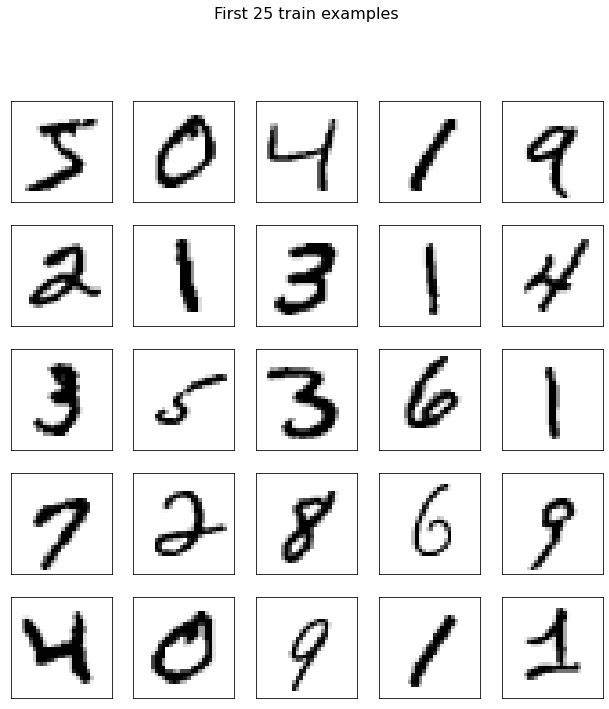

In [111]:
show_table_images(X_train.numpy()[:25], "First 25 train examples", 5)

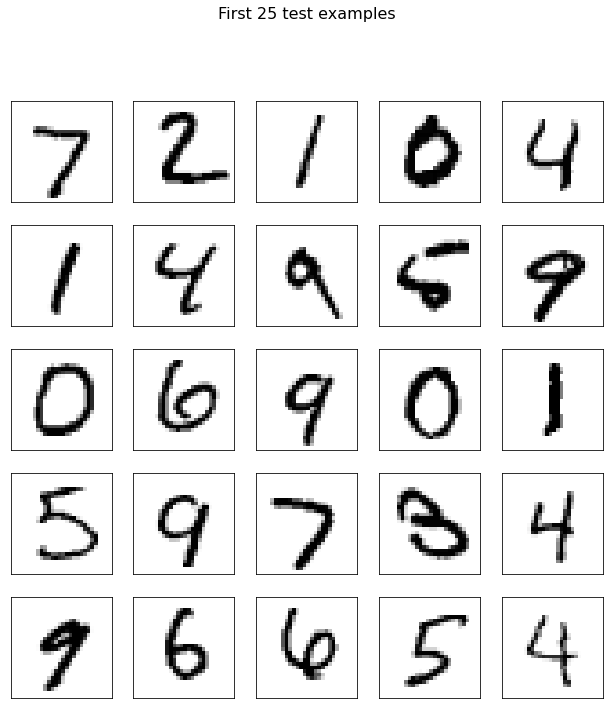

In [ ]:
show_table_images(X_test.numpy()[:25], "First 25 test examples", 5)

## Autoencoders

I choose to implement the DENOISING AUTOENCODERS.

In [ ]:
def add_noise(X, mean = 0, std = 0.2):
  """
    Given X as a tensor, returns the X with gaussina noise added,
    the gaussian noise is sampled with mean and std.

    Args:
        X (torch.Tensor): A torch Tensor with element in [0-1].
        mean (int): mean of the gaussian noise.
        std (int): standard deviation of the gaussian noise.
    Returns:
        torch.Tensor: A torch Tensor with noise added.
  """

  # add gaussian noise
  return X + torch.randn(X.shape)*std + mean

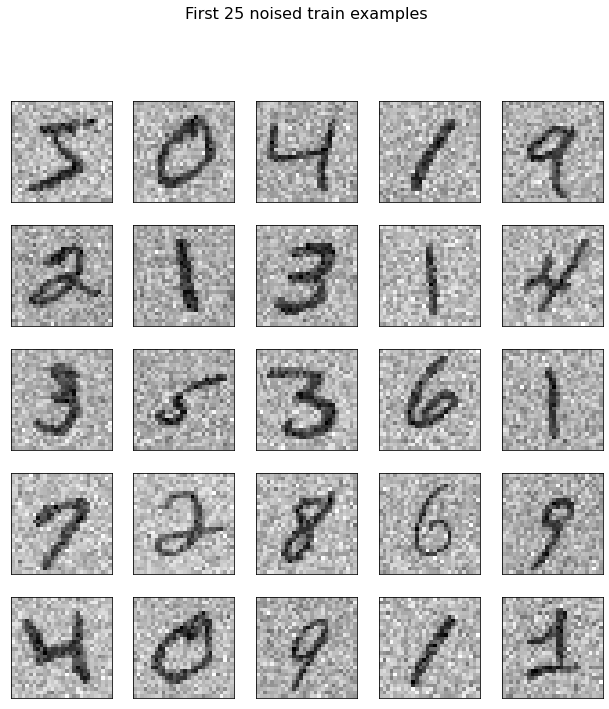

In [ ]:
show_table_images(add_noise(X_train[:25]).numpy(), "First 25 noised train examples", 5)

In [ ]:
def evaluate_MSE(model, eval_dataset):
  """
    Given an autoencoder model and a dataset,
    return the MSE of the reconstruction.

    Args:
        model (torch.nn.Module): An autoencoder model.
        eval_dataset (torch.Tensor) A dataset.
    Returns:
        float: MSE of the reconstruction over eval_dataset.
  """

  model.to(device)
  eval_dataset = eval_dataset.to(device)

  with torch.no_grad():
    eval_output = model(eval_dataset)

    loss = F.mse_loss(eval_output, eval_dataset)
  
  return loss.item()

In [58]:
def denoising_autoencoder_training(model, X_train, epochs, batch_size, learning_rate, X_test=None):
  """
    Function to train a denoising autoencoder.
    Use the ADAM as optimizer and the MSE as loss function.

    Args:
        model (torch.nn.Module): An autoencoder model.
        X_train (torch.Tensor) Training dataset.
        epochs (int): number of training epochs.
        batch_size (int): number of elements in each mini-batch.
        learning_rate (float): the learning rate parameter of the ADAM optimizer.
        X_test (torch.Tensor): Test dataset.
    Returns:
        dict: loss curve over training and test datasets.
  """

  # need to pass over the dataloader to avoid errors (not training) on cpu execution
  train_loader = torch.utils.data.DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)

  model = model.to(device)

  # create an optimizer object
  # Adam optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # mean-squared error loss
  criterion = nn.MSELoss()

  history = {"train_errors": [], "test_errors" : []}

  for epoch in range(epochs):
    model.train()
    for data in train_loader:
      X_batch = data[0]

      batch_features_in = add_noise(X_batch).to(device)
      X_batch = X_batch.to(device)
      
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
      optimizer.zero_grad()

      # compute reconstructions
      outputs = model(batch_features_in)
      
      # compute training reconstruction loss
      train_loss = criterion(outputs, X_batch)      
      
      # compute accumulated gradients
      train_loss.backward()
      
      # perform parameter update based on current gradients
      optimizer.step()
                      
    # compute the error statistics over the traing and test dataset (if present)
    epoch_train_error = evaluate_MSE(model, X_train)
    history["train_errors"].append(epoch_train_error)

    if X_test is None:
      print(f"epoch : {epoch + 1}/{epochs}, train loss = {epoch_train_error:.6f}")
    else:
      epoch_test_error = evaluate_MSE(model, X_test)
      history["test_errors"].append(epoch_test_error)
      print(f"epoch : {epoch + 1}/{epochs}, train loss = {epoch_train_error:.6f}, test loss = {epoch_test_error:.6f}")

  return history

### Single layer AutoEncoder

In [ ]:
class AE(nn.Module):
  def __init__(self, input_shape=784, hidden_dimension=128, last=True):
      super().__init__()

      self.encoder_layer = nn.Linear(
          in_features=input_shape, out_features=hidden_dimension
      )
      self.decoder_layer = nn.Linear(
          in_features=hidden_dimension, out_features=input_shape
      )

      self.encoder_act = nn.ReLU()
      if last:
        self.decoder_act = nn.Sigmoid()
      else:
        self.decoder_act = nn.ReLU()


  def encode(self, X):
    """
      Encode method of the autoencoder.

      Args:
          X (torch.nn.Tensor): input tensor to encode.
      Returns:
          torch.nn.Tensor: encoded tensor.
    """

    hidden = self.encoder_layer(X)
    encoded = self.encoder_act(hidden)
    
    return encoded

  def decode(self, X):
    """
      Decode method of the autoencoder.

      Args:
          X (torch.nn.Tensor): input tensor to decode.
      Returns:
          torch.nn.Tensor: decoded tensor.
    """

    output = self.decoder_layer(X)
    decoded = self.decoder_act(output)

    return decoded

  def forward(self, features):
    encoded = self.encode(features)
    decoded = self.decode(encoded)
    return decoded

The chooses of the various hyperparameters are done after a screening phase, the comparison metric that lead me to the choosen hyperparameters didn't rely on the test error, which was added after the final choices for a better visualization of the performances.
The performances reported in the following sections refer to the MSE w.r.t the output of the networks and the input without the noise part added.  

In [ ]:
# define the number of epochs common to all shallow autoencoder training executions
epochs = 20

Defining the Autoencoder object.

Showing the computational graph of the forward phase of a shallow autoencoder

In [59]:
ae = AE(input_shape=784, hidden_dimension=128)

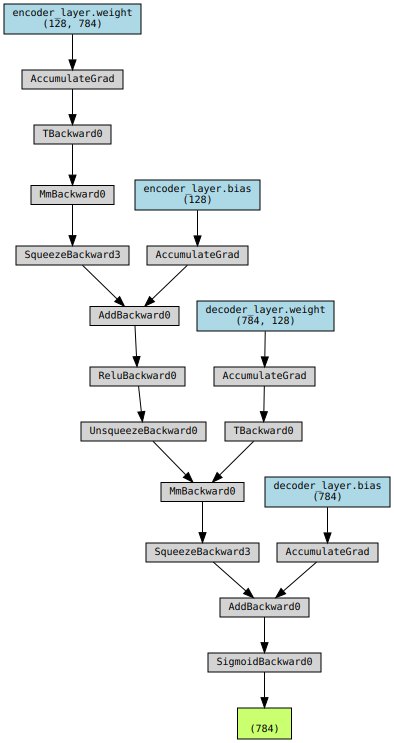

In [ ]:
make_dot(ae(X_train[0]), params=dict(ae.named_parameters()))

Training the Autoencoder for 20 epochs with batch size of 128 and a learnign rate of 0.001 (ADAM OPTIMIZER)

In [60]:
history_ae = denoising_autoencoder_training(ae, X_train, epochs, 128, 1e-3, X_test=X_test)

epoch : 1/20, train loss = 0.016673, test loss = 0.016434
epoch : 2/20, train loss = 0.007920, test loss = 0.007812
epoch : 3/20, train loss = 0.005454, test loss = 0.005431
epoch : 4/20, train loss = 0.004378, test loss = 0.004391
epoch : 5/20, train loss = 0.003815, test loss = 0.003846
epoch : 6/20, train loss = 0.003376, test loss = 0.003426
epoch : 7/20, train loss = 0.003122, test loss = 0.003185
epoch : 8/20, train loss = 0.002861, test loss = 0.002944
epoch : 9/20, train loss = 0.002745, test loss = 0.002836
epoch : 10/20, train loss = 0.002608, test loss = 0.002707
epoch : 11/20, train loss = 0.002488, test loss = 0.002591
epoch : 12/20, train loss = 0.002435, test loss = 0.002548
epoch : 13/20, train loss = 0.002397, test loss = 0.002507
epoch : 14/20, train loss = 0.002357, test loss = 0.002469
epoch : 15/20, train loss = 0.002289, test loss = 0.002406
epoch : 16/20, train loss = 0.002235, test loss = 0.002356
epoch : 17/20, train loss = 0.002212, test loss = 0.002336
epoch 

Plotting the traing and test error curve, we can see that the model fits well the training set as well as the test set

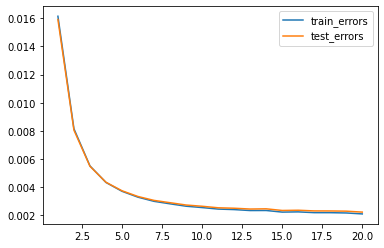

In [ ]:
plt.plot(np.arange(epochs)+1, history_ae["train_errors"], label='train_errors')
plt.plot(np.arange(epochs)+1, history_ae["test_errors"], label="test_errors")
plt.legend()
plt.show()

In [ ]:
print(f"Shallow Train MSE: {evaluate_MSE(ae, X_train)}")
print(f"Shallow Test MSE: {evaluate_MSE(ae, X_test)}")

Shallow Train MSE: 0.0020870626904070377
Shallow Test MSE: 0.002215569606050849


### Deep AutoEncoder

In [ ]:
class DAE(nn.Module):
  """
    Deep Auto Encoder class.
    It's implemented using the shallow autoencoder class, each layer is a shallow
    autoencoder, them are putted into a list.

    Args:
        input_shape (int): the input dimension.
        hidden_layers (list): the dimensions of the hidden layers (at least 2).
  """

  def __init__(self, input_shape, hidden_layers=[128, 128]):
    super().__init__()

    if len(hidden_layers) < 2:
      raise Exception("Deep Autoencoders have at least 2 hidden layers")

    self.autoencoders = [AE(input_shape, hidden_layers[0])]
    
    for dim_in, dim_out in zip(hidden_layers[:-2], hidden_layers[1:-1]):
      self.autoencoders.append(AE(dim_in, dim_out, last=False))
    self.autoencoders.append(AE(hidden_layers[-2], hidden_layers[-1], last=False))

    self.autoencoders = nn.ModuleList(self.autoencoders)

  def encode(self, X):
    """
      Encode method of the autoencoder.

      Args:
          X (torch.nn.Tensor): input tensor to encode.
      Returns:
          torch.nn.Tensor: encoded tensor.
    """
    
    encoded = X
    for autoencoder in self.autoencoders:
      encoded = autoencoder.encode(encoded)
    return encoded

  def decode(self, X):
    """
      Decode method of the autoencoder.

      Args:
          X (torch.nn.Tensor): input tensor to decode.
      Returns:
          torch.nn.Tensor: decoded tensor.
    """

    decoded = X
    for autoencoder in self.autoencoders[::-1]:
      decoded = autoencoder.decode(decoded)
    return decoded

  def forward(self, X):
    encoded = self.encode(X)
    decoded = self.decode(encoded)
    return decoded

In the following cell there is the function that permit the pretraining of a deep denoise autoencoder, I train all Shallow Autoencoder in the Deep one, the i-autoencoder is trained on the noised latent representation of the (i-1)-autoencoder, the first latent representation is given by the first autoencoder's encoder part taking in input the clear dataset.

In [ ]:
def denoising_autoencoder_pretraining(model, X_train, epochs, batch_size, learning_rate):
  """
    Perform layer-wise pretraining of a deep denoising autoencoder.
    Based on the denoising_autoencoder_training function to learn each layer.

    Args:
        model (torch.nn.Module): a deep autoencoder model.
        X_train (torch.Tensor) Training dataset.
        epochs (int): number of training epochs for each layer.
        batch_size (int): number of elements in each mini-batch for each layer.
        learning_rate (float): the learning rate parameter of the ADAM optimizer for each layer.
  """

  for autoencoder in model.autoencoders:
    denoising_autoencoder_training(autoencoder, X_train, epochs, batch_size, learning_rate)
    
    # create the latent space rapresentation of the shallow autoencoder's hidden layer just trained
    with torch.no_grad():  
      X_train = autoencoder.encode(X_train.to(device))
      X_train = X_train.cpu() # move the dataset to the cpu

In [72]:
deep_autoencoders_layers = [512, 256, 128]

to train the deep autoencoders are needed more epochs

In [73]:
# define the number of epochs common to all deep autoencoder training executions
epochs_deep = 40

### Denoising AutoEncoder with only pretraining

Defining the Deep Autoencoder that will be learned only with the pretraining phase

In [74]:
dae1 = DAE(784, deep_autoencoders_layers)

Showing the computational graph of the forward phase of a deep autoencoder


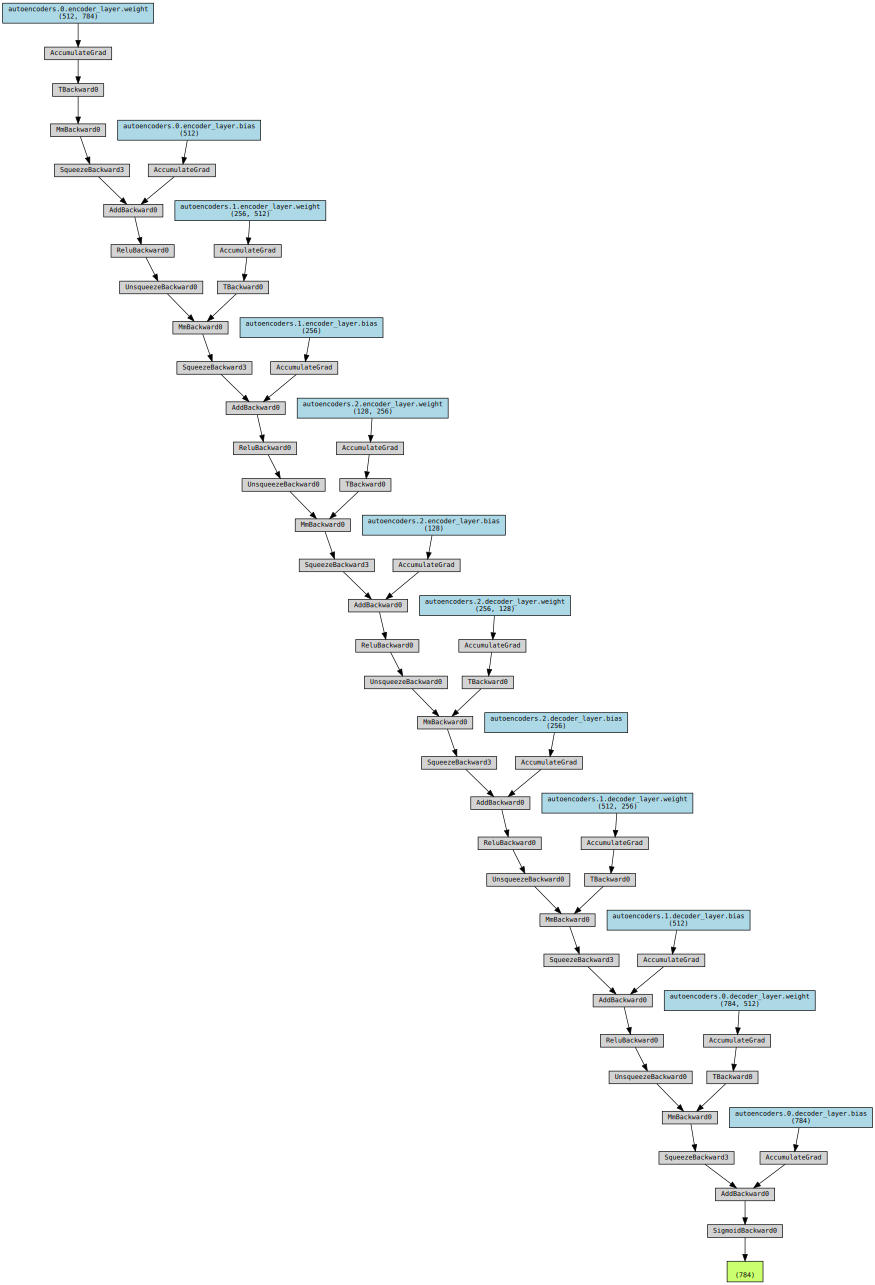

In [75]:
make_dot(dae1(X_train[0]), params=dict(dae1.named_parameters()))

Doing pretraining for 20 epochs at each layer with a batch size of 128 and a learning rate of 0.001 (ADAM OPTIMIZER)

In [76]:
denoising_autoencoder_pretraining(dae1, X_train, epochs, 128, 1e-3)

epoch : 1/20, train loss = 0.009000
epoch : 2/20, train loss = 0.004605
epoch : 3/20, train loss = 0.003320
epoch : 4/20, train loss = 0.002610
epoch : 5/20, train loss = 0.002288
epoch : 6/20, train loss = 0.002077
epoch : 7/20, train loss = 0.001929
epoch : 8/20, train loss = 0.001850
epoch : 9/20, train loss = 0.001681
epoch : 10/20, train loss = 0.001614
epoch : 11/20, train loss = 0.001588
epoch : 12/20, train loss = 0.001505
epoch : 13/20, train loss = 0.001487
epoch : 14/20, train loss = 0.001501
epoch : 15/20, train loss = 0.001473
epoch : 16/20, train loss = 0.001458
epoch : 17/20, train loss = 0.001401
epoch : 18/20, train loss = 0.001396
epoch : 19/20, train loss = 0.001418
epoch : 20/20, train loss = 0.001363
epoch : 1/20, train loss = 0.106017
epoch : 2/20, train loss = 0.073289
epoch : 3/20, train loss = 0.063541
epoch : 4/20, train loss = 0.058598
epoch : 5/20, train loss = 0.055830
epoch : 6/20, train loss = 0.054096
epoch : 7/20, train loss = 0.050471
epoch : 8/20, tra

Showing the overall performances of the model over the train and test datasets

In [77]:
print(f"Only pretraining Train MSE: {evaluate_MSE(dae1, X_train)}")
print(f"Only pretraining Test MSE: {evaluate_MSE(dae1, X_test)}")

Only pretraining Train MSE: 0.008415098302066326
Only pretraining Test MSE: 0.008461355231702328


### Denoising AutoEncoder with only fine tuning

Defining the Deep Autoencoder that will be learned only with fine tuning

In [78]:
dae2 = DAE(784, deep_autoencoders_layers)

Doing fine tuning for 40 epochs with batch size of 128 and learning rate of 0.001 (ADAM OPTIMIZER)



In [79]:
history_dae2 = denoising_autoencoder_training(dae2, X_train, epochs_deep, 128, 1e-3, X_test=X_test)

epoch : 1/40, train loss = 0.026253, test loss = 0.026075
epoch : 2/40, train loss = 0.018530, test loss = 0.018398
epoch : 3/40, train loss = 0.014303, test loss = 0.014224
epoch : 4/40, train loss = 0.012362, test loss = 0.012342
epoch : 5/40, train loss = 0.010798, test loss = 0.010851
epoch : 6/40, train loss = 0.009703, test loss = 0.009849
epoch : 7/40, train loss = 0.008737, test loss = 0.008910
epoch : 8/40, train loss = 0.008345, test loss = 0.008542
epoch : 9/40, train loss = 0.007768, test loss = 0.008019
epoch : 10/40, train loss = 0.007550, test loss = 0.007823
epoch : 11/40, train loss = 0.006975, test loss = 0.007272
epoch : 12/40, train loss = 0.006720, test loss = 0.007027
epoch : 13/40, train loss = 0.006619, test loss = 0.006928
epoch : 14/40, train loss = 0.006238, test loss = 0.006584
epoch : 15/40, train loss = 0.006172, test loss = 0.006517
epoch : 16/40, train loss = 0.006023, test loss = 0.006376
epoch : 17/40, train loss = 0.005835, test loss = 0.006206
epoch 

Showing the error curve over the train and test dataset, we can see that the error go down well for train dataset as well as test dataset.

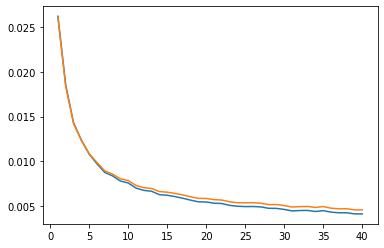

In [80]:
plt.plot(np.arange(epochs_deep)+1, history_dae2["train_errors"], label='train_errors')
plt.plot(np.arange(epochs_deep)+1, history_dae2["test_errors"], label="test_errors")
plt.show()

In [81]:
print(f"Pretraining and fine tuning Train MSE: {evaluate_MSE(dae2, X_train)}")
print(f"Pretraining and fine tuning Test MSE: {evaluate_MSE(dae2, X_test)}")

Pretraining and fine tuning Train MSE: 0.004077807068824768
Pretraining and fine tuning Test MSE: 0.004526559263467789


### Denoising AutoEncoder with pretraining and fine tuining

Defining the Deep Autoencoder that will be learned with pretraining phase and with additional fine tuning phase

In [82]:
dae3 = DAE(784, deep_autoencoders_layers)

Doing pretraining with 20 epochs for each layer, batch size of 128 and learning rate of 0.001 (ADAM OPTIMIZER)

In [83]:
denoising_autoencoder_pretraining(dae3, X_train, epochs, 128, 1e-3)

epoch : 1/20, train loss = 0.008789
epoch : 2/20, train loss = 0.004476
epoch : 3/20, train loss = 0.003226
epoch : 4/20, train loss = 0.002652
epoch : 5/20, train loss = 0.002456
epoch : 6/20, train loss = 0.002080
epoch : 7/20, train loss = 0.001920
epoch : 8/20, train loss = 0.001843
epoch : 9/20, train loss = 0.001741
epoch : 10/20, train loss = 0.001703
epoch : 11/20, train loss = 0.001634
epoch : 12/20, train loss = 0.001555
epoch : 13/20, train loss = 0.001555
epoch : 14/20, train loss = 0.001501
epoch : 15/20, train loss = 0.001498
epoch : 16/20, train loss = 0.001453
epoch : 17/20, train loss = 0.001442
epoch : 18/20, train loss = 0.001494
epoch : 19/20, train loss = 0.001412
epoch : 20/20, train loss = 0.001385
epoch : 1/20, train loss = 0.107280
epoch : 2/20, train loss = 0.073495
epoch : 3/20, train loss = 0.063233
epoch : 4/20, train loss = 0.058321
epoch : 5/20, train loss = 0.055817
epoch : 6/20, train loss = 0.054473
epoch : 7/20, train loss = 0.053595
epoch : 8/20, tra

Doing fine tuning with 40 epochs, batch size of 128 and learning rate of 0.001 (ADAM OPTIMIZER)

In [84]:
history_dae3 = denoising_autoencoder_training(dae3, X_train, epochs_deep, 128, 1e-3, X_test=X_test)

epoch : 1/40, train loss = 0.004656, test loss = 0.004751
epoch : 2/40, train loss = 0.004487, test loss = 0.004597
epoch : 3/40, train loss = 0.004561, test loss = 0.004690
epoch : 4/40, train loss = 0.004394, test loss = 0.004528
epoch : 5/40, train loss = 0.004289, test loss = 0.004440
epoch : 6/40, train loss = 0.004133, test loss = 0.004310
epoch : 7/40, train loss = 0.004000, test loss = 0.004165
epoch : 8/40, train loss = 0.004088, test loss = 0.004294
epoch : 9/40, train loss = 0.003862, test loss = 0.004067
epoch : 10/40, train loss = 0.004109, test loss = 0.004317
epoch : 11/40, train loss = 0.003735, test loss = 0.003970
epoch : 12/40, train loss = 0.003689, test loss = 0.003926
epoch : 13/40, train loss = 0.003933, test loss = 0.004197
epoch : 14/40, train loss = 0.003630, test loss = 0.003872
epoch : 15/40, train loss = 0.003658, test loss = 0.003921
epoch : 16/40, train loss = 0.003723, test loss = 0.003986
epoch : 17/40, train loss = 0.003540, test loss = 0.003818
epoch 

Showing the perfomance plotting the learning curve over train and test datasets, we can see that the network learn well and the error goes down in both curves (train and test).

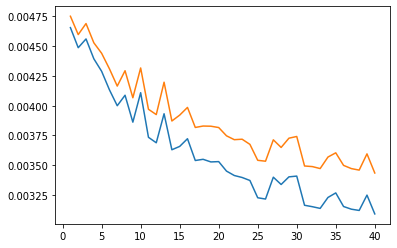

In [85]:
plt.plot(np.arange(epochs_deep)+1, history_dae3["train_errors"], label='train_errors')
plt.plot(np.arange(epochs_deep)+1, history_dae3["test_errors"], label="test_errors")
plt.show()

In [86]:
print(f"Pretraining and fine tuning Train MSE: {evaluate_MSE(dae3, X_train)}")
print(f"Pretraining and fine tuning Test MSE: {evaluate_MSE(dae3, X_test)}")

Pretraining and fine tuning Train MSE: 0.0030915860552340746
Pretraining and fine tuning Test MSE: 0.0034350911155343056


### Considerations

The metric used in the experiments is the MSE error of the models w.r.t. the reconstruction of the clear input. In the experiments done until now we can see several things, the shallow auto encoder can reach very good performance in 20 epochs.
From the several Deep Autoencoders we can see that we have a worsts result, maybe due to the higher non linearity in the hidden neurons. The dae1 (only pretraining) can't reach the same performances of the dae2 (only fine tuning) and even more does worst w.r.t the shallow one. In addition we can notice, seeing the curves of dae2 and dae3, that the pretraining can lead to faster training phase, but at the end dae2 and dae3 reach comparable performances (dae3 is slightly better). 

Even the worsts results, for the last section I will use the dae3 model.

In [87]:
model = dae3.cpu()

## Latent space interpolation

In this section I will take three images from the test dataset, two represent the digit 0 and one represents digit 1.
On each digit I apply the encoder part of the choosen model, retrieiving the latent space representations, with thoose representations I will show how the model decode various convex combinations of two of them, the two digit 0 and the digit 1 with a digit 0 latent space representations

In [88]:
# get three images, two from the same class and the third of another class

zero_class = y_test == 0
one_class = y_test == 1

z1 = X_test[zero_class][0]
z2 = X_test[zero_class][1]
z3 = X_test[one_class][0]

show the original imamges

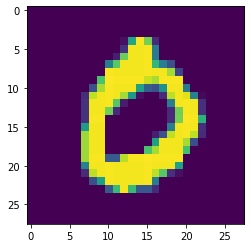

In [89]:
plt.imshow(z1.view((28,28)))
plt.show()

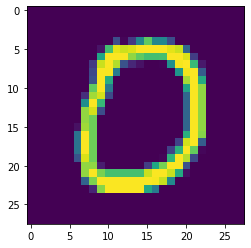

In [90]:
plt.imshow(z2.view((28,28)))
plt.show()

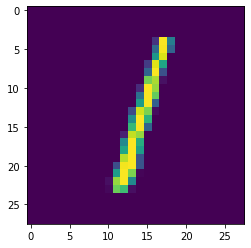

In [91]:
plt.imshow(z3.view((28,28)))
plt.show()

show the reconstructions

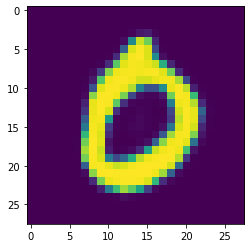

In [92]:
plt.imshow(model(z1).detach().view(28,28))
plt.show()

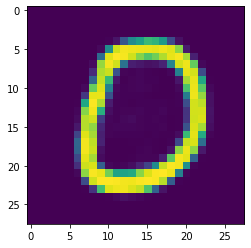

In [93]:
plt.imshow(model(z2).detach().view(28,28))
plt.show()

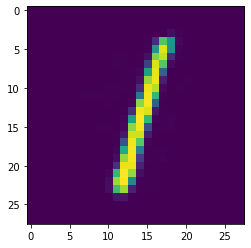

In [94]:
plt.imshow(model(z3).detach().view(28,28))
plt.show()

We can see that the model can reconstruct well the images graphically, this is expected because the MSE error is quite low in the training and test datasets.

In [95]:
def latent_space_interpolation(model, image1, image2):
  """
    Performance the latent space interpolation.
    Taking the two latent representations generated by the autoencoder model from the image1 and image2,
    get the decoding of some convex combination of the latent representations,
    and plot them.

    Args:
        model (torch.nn.Module): An autoencoder model.
        image1 (torch.Torch): first image.
        image2 (torch.Torch): second image.
  """

  with torch.no_grad():
    enc1 = model.encode(image1)
    enc2 = model.encode(image2)

    progression_imgaes = [model.decode(enc2)]

    for i in range(1,10):

      alpha = i/10

      enc = alpha*enc1 + (1-alpha)*enc2

      dec = model.decode(enc)

      progression_imgaes.append(dec)

    progression_imgaes.append(model.decode(enc1))


  plt.figure(figsize=(11*2, 11*2))
  for i, comp in enumerate(progression_imgaes):
      plt.subplot(11, 11, (i + 1))
      plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest", )
      plt.title(f"alpha = {i/10}")
      plt.xticks(())
      plt.yticks(())
  plt.suptitle("Progression of the decoder fitted with convex comb. of two encoded images", fontsize=16)
  plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

  plt.show()

Show reconstruction of the convex combination of the two digit 0 latent space representations for $\alpha \in (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)$

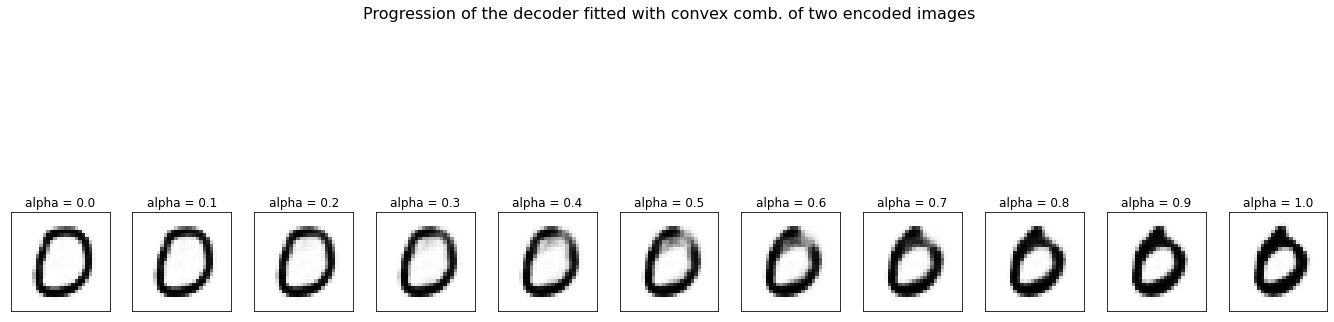

In [96]:
latent_space_interpolation(model, z1, z2)

Show reconstruction of the convex combination of the digit 1 and a digit 0 latent space representations for $\alpha \in (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)$

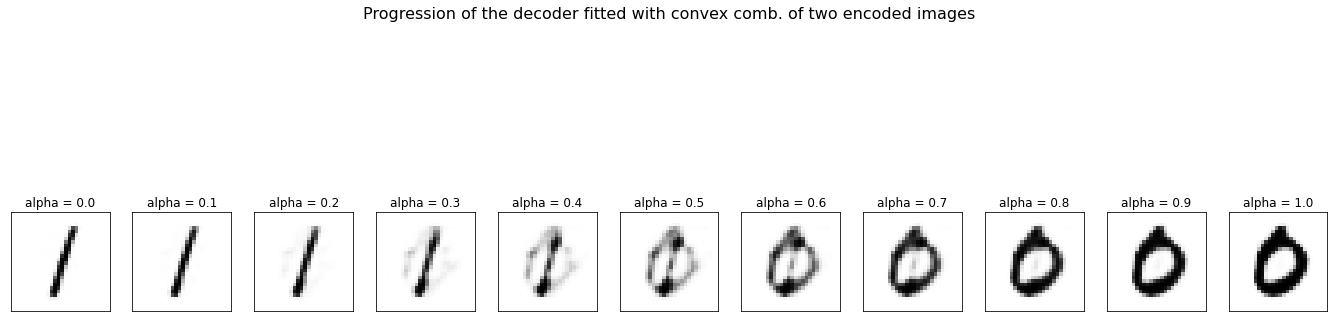

In [97]:
latent_space_interpolation(model, z1, z3)

We can see how the latent space convex interpolations produce images that are smoothly between the two start images, we can see how the network retrieve outputs that seemsly are in the data manifold without destroy completly the data structure.

## Iterative Gradient Ascent

In this section I will exploit the property of the denoiser autoencoders:

$g(f(x)) - x \propto \frac{\partial log(P(x))}{\partial x}$

So, given a radom input $x$ I can maximize the probability $P$ of the input belong to the dataset distribution applying the iterative gradient ascent, taking the random input and passing iterativelly through the autoencoder.

In [98]:
def iterative_gradient_ascent(model):
  """
    Given an autoencoder perform the iterative gradient ascent of the 
    probability of an input image to be in the training data's manifold,
    starting with a random sampled image.
    Plot 16 time step of the gradient ascent.

    Args:
        model (torch.nn.Module): An autoencoder model.
        latent1 (torch.Torch): first latent representation.
        latent2 (torch.Torch): second latent representation.
  """

  with torch.no_grad():
    rand_img = torch.rand(784)

    gradient_ascent_images = [rand_img.clone()]

    for i in range(15):
      recon = model(rand_img)
      delta_p = recon - rand_img
      rand_img += 0.3*delta_p
      gradient_ascent_images.append(rand_img.clone())

    show_table_images(gradient_ascent_images, "First 25 iterations of gradient ascent", 4)

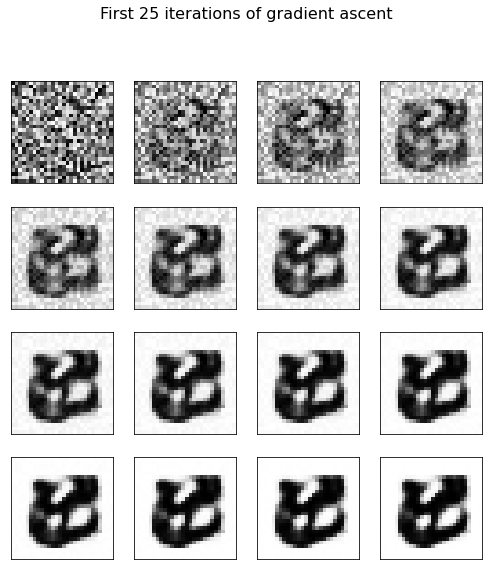

In [99]:
iterative_gradient_ascent(model)

We can see how iterativelly the input converge to an image that more or less has a some kind of structure like in the mnist images.



## Iterative Gradient Ascent for a single class learned autoencoder

To see better the convergence of the random input to the data manifold we can do the same iterative gradient ascent but on a model trained over a single digit (in this case 4), having more recognizable structure.

In [106]:
model_single = AE(input_shape=784, hidden_dimension=128)

In [107]:
_ = denoising_autoencoder_training(model_single, X_train[y_train==4], 20, 64, 1e-3, X_test = X_test[y_test==4])

epoch : 1/20, train loss = 0.039049, test loss = 0.038486
epoch : 2/20, train loss = 0.026296, test loss = 0.025651
epoch : 3/20, train loss = 0.020685, test loss = 0.020136
epoch : 4/20, train loss = 0.017413, test loss = 0.017021
epoch : 5/20, train loss = 0.014806, test loss = 0.014432
epoch : 6/20, train loss = 0.012658, test loss = 0.012391
epoch : 7/20, train loss = 0.011127, test loss = 0.010897
epoch : 8/20, train loss = 0.009878, test loss = 0.009763
epoch : 9/20, train loss = 0.008878, test loss = 0.008809
epoch : 10/20, train loss = 0.008040, test loss = 0.008017
epoch : 11/20, train loss = 0.007355, test loss = 0.007333
epoch : 12/20, train loss = 0.006862, test loss = 0.006913
epoch : 13/20, train loss = 0.006347, test loss = 0.006380
epoch : 14/20, train loss = 0.005913, test loss = 0.006022
epoch : 15/20, train loss = 0.005545, test loss = 0.005652
epoch : 16/20, train loss = 0.005247, test loss = 0.005394
epoch : 17/20, train loss = 0.004941, test loss = 0.005081
epoch 

In [108]:
print(f"Single digit fine tuning Train MSE: {evaluate_MSE(model_single, X_train[y_train==4])}")
print(f"Single digit fine tuning Test MSE: {evaluate_MSE(model_single, X_test[y_test==4])}")

Single digit fine tuning Train MSE: 0.0042620315216481686
Single digit fine tuning Test MSE: 0.004411567002534866


In [109]:
model_single = model_single.cpu()

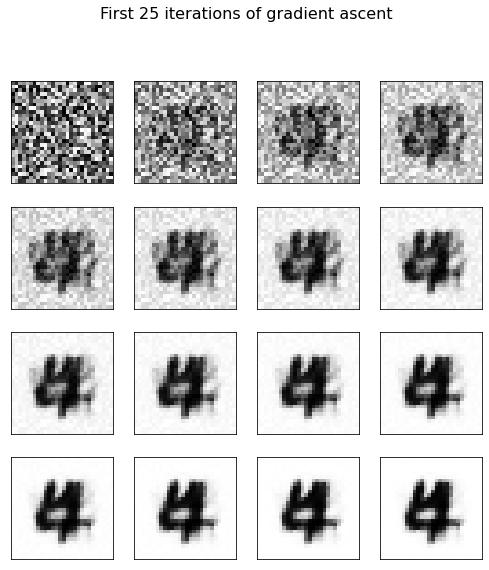

In [110]:
iterative_gradient_ascent(model_single)

In this case we can see the convergence to an image that represent the structure of a digit 4.

## Conclusions

As already sayd the parameters of the networks in the experiments are choosen out of a very rough screening phase, more effort w.r.t hyper-parameters selection and network structure could be done, even for the choice of the noise's variance, but I think that the results are already satisfactory to see practically theoretical results seen in class.